In [7]:
import os
import urllib
import pandas as pd
import numpy as np
from sqlalchemy import create_engine


In [8]:

# --- 1. Get data from SQL Server ---

# Build the connection string
params = urllib.parse.quote_plus(
    "DRIVER={SQL Server};"
    "SERVER=maciek_d;"
    "DATABASE=retail_online;"
    "Trusted_Connection=yes;"
)
# Create an engine using SQLAlchemy's
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

# Use pd.read_sql with the SQLAlchemy engine
query = "SELECT * FROM OrginalData"
df = pd.read_sql(query, engine)

# Show the first few rows of the DataFrame


In [9]:
# --- 2. Quick data analysis ---
df.head()

,InvoiceNo,StockCode,DescriptionProd,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Client,Email
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,Bridget Mccabe,bridget.mccabe@example.com
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Bridget Mccabe,bridget.mccabe@example.com
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,Bridget Mccabe,bridget.mccabe@example.com
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Bridget Mccabe,bridget.mccabe@example.com
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Bridget Mccabe,bridget.mccabe@example.com


In [10]:
df.dtypes

InvoiceNo                  object
StockCode                  object
DescriptionProd            object
Quantity                    int64
InvoiceDate        datetime64[ns]
UnitPrice                 float64
CustomerID                 object
Country                    object
Client                     object
Email                      object
dtype: object

In [11]:
df.isnull().sum()

InvoiceNo               0
StockCode               0
DescriptionProd      1454
Quantity                0
InvoiceDate             0
UnitPrice               0
CustomerID         135080
Country                 0
Client                  0
Email                   0
dtype: int64

In [12]:
# --- 3. Basic data cleaning ---

In [13]:
#check if there are InvoiceNo that have assign CustomerID but have also missing CustomerID 
invoice_counts = df.groupby('InvoiceNo')['CustomerID'].agg(['count', 'nunique'])
a = len(invoice_counts[invoice_counts['nunique'] > 1])
print(a)
#a = 0  so that there are no InvoiceNo that have assign CustomerID but have also missing CustomerID - CustomerID cant be populated for such examples


0


In [14]:


#add some dummy CustomerID for InvoiceNo that have NULL CustomerID
unique_invoices_with_nulls = df[df['CustomerID'].isnull()]['InvoiceNo'].unique()

# Create a mapping: assign unique CustomerID (-1, -2, -3, ...) to each InvoiceNo with NULL CustomerID
invoice_to_customer_mapping = {invoice: int(-(i + 1)) for i, invoice in enumerate(unique_invoices_with_nulls)}

# Assign new CustomerID values where they were previously NULL
df.loc[df['InvoiceNo'].isin(invoice_to_customer_mapping.keys()) & df['CustomerID'].isnull(), 'CustomerID'] = df['InvoiceNo'].map(invoice_to_customer_mapping)
df['CustomerID'] = df['CustomerID'].astype(int).astype(str)

# Check if there are still NULL values in CustomerID
print("Number of NULLs in CustomerID after update:", df['CustomerID'].isnull().sum())

Number of NULLs in CustomerID after update: 0


In [15]:
#check if there are different DescriptionProd for the same StockCode
stockcode_counts = df.groupby('StockCode')['DescriptionProd'].agg(['count', 'nunique'])
stockcode_counts = stockcode_counts[stockcode_counts['nunique'] > 1]
print("Number of StockCodes with different DescriptionProd:", len(stockcode_counts))

Number of StockCodes with different DescriptionProd: 650


In [16]:

def longest_desc(series):
    non_null = series.dropna()
    if len(non_null) > 0:
        # Use Python's max() with a key that returns the length of the string
        return max(non_null, key=lambda s: len(s))
    else:
        return np.nan

# Build a mapping from StockCode to the longest DescriptionProd found for that code
longest_desc_map = df.groupby("StockCode")["DescriptionProd"].apply(longest_desc).to_dict()

# Replace the DescriptionProd values by mapping each StockCode to its longest description.
df['DescriptionProd'] = df['StockCode'].map(longest_desc_map)

df['DescriptionProd'] = df['DescriptionProd'].fillna('Unknown Description')

In [17]:
df[df['DescriptionProd'] == 'Unknown Description'].head(10)

,InvoiceNo,StockCode,DescriptionProd,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Client,Email
1970,536545,21134,Unknown Description,1,2010-12-01 14:32:00,0.0,-3,United Kingdom,Lorraine Scarbrough,lorraine.scarbrough@example.com
1987,536549,85226A,Unknown Description,1,2010-12-01 14:34:00,0.0,-6,United Kingdom,Lorraine Scarbrough,lorraine.scarbrough@example.com
1988,536550,85044,Unknown Description,1,2010-12-01 14:34:00,0.0,-7,United Kingdom,Lorraine Scarbrough,lorraine.scarbrough@example.com
2024,536552,20950,Unknown Description,1,2010-12-01 14:34:00,0.0,-8,United Kingdom,Lorraine Scarbrough,lorraine.scarbrough@example.com
2026,536554,84670,Unknown Description,23,2010-12-01 14:35:00,0.0,-10,United Kingdom,Lorraine Scarbrough,lorraine.scarbrough@example.com
7187,536995,35951,Unknown Description,57,2010-12-03 15:29:00,0.0,-36,United Kingdom,Lorraine Scarbrough,lorraine.scarbrough@example.com
7193,537001,21653,Unknown Description,-6,2010-12-03 15:33:00,0.0,-42,United Kingdom,Lorraine Scarbrough,lorraine.scarbrough@example.com
19628,537875,20849,Unknown Description,1,2010-12-08 18:08:00,0.0,-133,United Kingdom,Lorraine Scarbrough,lorraine.scarbrough@example.com
19631,537878,72803B,Unknown Description,1,2010-12-08 18:09:00,0.0,-136,United Kingdom,Lorraine Scarbrough,lorraine.scarbrough@example.com
21782,538133,85018C,Unknown Description,3,2010-12-09 15:56:00,0.0,-167,United Kingdom,Lorraine Scarbrough,lorraine.scarbrough@example.com


In [18]:
#Check how many rows have UnitPrice <= 0, delete them
print((df['UnitPrice'] <= 0).sum())
df = df[df['UnitPrice'] > 0]

2521


In [19]:
short_strings = df[df['DescriptionProd'].str.len() <= 4]['DescriptionProd']
print(short_strings)

Series([], Name: DescriptionProd, dtype: object)


In [20]:
# --- 4. Create dim tables : ---

In [21]:
#Create table dim_date
df_transform = df.copy()
dim_date = df[['InvoiceDate']].copy()
dim_date['Date'] = dim_date['InvoiceDate'].dt.date
dim_date = dim_date.drop_duplicates()
dim_date['Year'] = dim_date['InvoiceDate'].dt.year
dim_date['Quarter'] = dim_date['InvoiceDate'].dt.quarter
dim_date['Month'] = dim_date['InvoiceDate'].dt.month
dim_date['Day'] = dim_date['InvoiceDate'].dt.day
dim_date['Weekday'] = dim_date['InvoiceDate'].dt.weekday
dim_date['Week'] = dim_date['InvoiceDate'].dt.isocalendar().week
dim_date['IsWeekend'] = dim_date['Weekday'].isin([5, 6]).astype(int)

dim_date = dim_date.sort_values('Date')
dim_date = dim_date.reset_index(drop=True)
# Generate unique key for each specific date
dim_date['DateKey'] = pd.factorize(dim_date['Date'])[0] + 1
df_transform = df_transform.merge(dim_date, how='left', left_on='InvoiceDate', right_on='InvoiceDate')
dim_date = dim_date[['DateKey', 'Date', 'Year', 'Quarter', 'Month', 'Day', 'Weekday', 'Week', 'IsWeekend']]
dim_date = dim_date.drop_duplicates().reset_index(drop=True)

dim_date.head()

,DateKey,Date,Year,Quarter,Month,Day,Weekday,Week,IsWeekend
0,1,2010-12-01,2010,4,12,1,2,48,0
1,2,2010-12-02,2010,4,12,2,3,48,0
2,3,2010-12-03,2010,4,12,3,4,48,0
3,4,2010-12-05,2010,4,12,5,6,48,1
4,5,2010-12-06,2010,4,12,6,0,49,0


In [22]:
# create more specific dim date table - with exact time of the invoice
dim_specific_date = df[['InvoiceDate']].copy()
dim_specific_date = dim_specific_date.drop_duplicates()

dim_specific_date['Hour'] = dim_specific_date['InvoiceDate'].dt.hour
dim_specific_date['Minute'] = dim_specific_date['InvoiceDate'].dt.minute
dim_specific_date = dim_specific_date.sort_values('InvoiceDate').reset_index(drop=True)

# Generate unique key for each specific date and time
dim_specific_date['DateTimeKey'] = pd.factorize(dim_specific_date['InvoiceDate'])[0] + 1
df_transform = df_transform.merge(dim_specific_date, how='left', left_on='InvoiceDate', right_on='InvoiceDate')
dim_specific_date = dim_specific_date[['DateTimeKey', 'Hour', 'Minute']]
dim_specific_date = dim_specific_date.drop_duplicates()
dim_specific_date.head()

,DateTimeKey,Hour,Minute
0,1,8,26
1,2,8,28
2,3,8,34
3,4,8,35
4,5,8,45


In [23]:
# create dim_customer table
dim_customer = df[['CustomerID', 'Country', 'Client', 'Email']].copy()
dim_customer = dim_customer.drop_duplicates(subset=['CustomerID']).reset_index(drop=True)
dim_customer['ClientName'] = dim_customer['Client'].apply(lambda x: x.split()[0])
dim_customer['ClientSurname'] = dim_customer['Client'].apply(lambda x: x.split()[-1])
dim_customer = dim_customer.rename(columns={'Client':'ClientFullName'})
dim_customer.head()



,CustomerID,Country,ClientFullName,Email,ClientName,ClientSurname
0,17850,United Kingdom,Bridget Mccabe,bridget.mccabe@example.com,Bridget,Mccabe
1,13047,United Kingdom,Darrell Ulrich,darrell.ulrich@example.com,Darrell,Ulrich
2,12583,France,Mike Lovell,mike.lovell@example.com,Mike,Lovell
3,13748,United Kingdom,Sylvia Austin,sylvia.austin@example.com,Sylvia,Austin
4,15100,United Kingdom,John Beckwith,john.beckwith@example.com,John,Beckwith


In [24]:
#create dim product table
dim_product = df[['StockCode', 'DescriptionProd', 'UnitPrice']].copy()
dim_product['StockCode'] = dim_product['StockCode'].str.upper()
dim_product['UnitPrice'] = pd.to_numeric(dim_product['UnitPrice'], errors='coerce')
dim_product['UnitPrice'] = dim_product['UnitPrice'].map(lambda x: f"{x:.2f}")


dim_product = dim_product.drop_duplicates(subset=['StockCode'], keep='last').reset_index(drop=True)

dim_product.head()

,StockCode,DescriptionProd,UnitPrice
0,84854,GIRLY PINK TOOL SET,4.95
1,20957,PORCELAIN HANGING BELL SMALL,1.45
2,82615,PINK MARSHMALLOW SCARF KNITTING KIT,2.55
3,35271S,GOLD PRINT PAPER BAG,0.19
4,21268,VINTAGE BLUE TINSEL REEL,0.42


In [25]:
# --- ML techniques to transform data ---
#Use LLM model to generate product categories - to get more specific data than in the original data

In [26]:
from transformers import pipeline
#Using GPU for better performance
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected. Running on CPU.")

# zero_shot model to perform classification, device = 0 for GPU
category_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)





c:\Users\dzimi\Documents\data_engineering\project_git\my_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.4.1+cu118
CUDA available: True
Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [27]:
import warnings
warnings.filterwarnings("ignore", message="Length of IterableDataset")

# Classify the descriptions in batches to avoid memory issues and speed up the process
descriptions = dim_product['DescriptionProd'].tolist()
batch_size = 32
all_categories = []
candidate_labels = ["Electronics", "Clothing", "Furniture", "Home Accessories", "Toys", "Sports", "Jewelry", "Cosmetics", "Office Supplies", "Tools"]

# return the category with the highest probability from the description
for i in range(0, len(descriptions), batch_size):
    batch = descriptions[i:i + batch_size]
    results = category_classifier(batch, candidate_labels=candidate_labels)
    if isinstance(results, dict):
        all_categories.append(results['labels'][0])
    else:
        for res in results:
            all_categories.append(res['labels'][0])

c:\Users\dzimi\Documents\data_engineering\project_git\my_venv\lib\site-packages\transformers\models\bart\modeling_bart.py:497: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [28]:
#assign the categories to the dim_product DataFrame
dim_product['Category'] = all_categories


In [29]:
# return color from the description
def extract_color(description):
    colors = ["Red", "Blue", "Green", "Black", "White", "Pink", "Yellow", "Purple", "Gray", "Grey", "Brown", "Orange", "Beige", "Gold", "Silver"]
    for color in colors:
        if color.lower() in description.lower():
            return color
    return "Unknown"

# Apply the function to the 'DescriptionProd' column
dim_product['Color'] = dim_product['DescriptionProd'].apply(extract_color)

In [30]:
dim_product.head(10)

,StockCode,DescriptionProd,UnitPrice,Category,Color
0,84854,GIRLY PINK TOOL SET,4.95,Toys,Pink
1,20957,PORCELAIN HANGING BELL SMALL,1.45,Home Accessories,Unknown
2,82615,PINK MARSHMALLOW SCARF KNITTING KIT,2.55,Toys,Pink
3,35271S,GOLD PRINT PAPER BAG,0.19,Office Supplies,Gold
4,21268,VINTAGE BLUE TINSEL REEL,0.42,Electronics,Blue
5,22275,WEEKEND BAG VINTAGE ROSE PAISLEY,7.65,Home Accessories,Unknown
6,16161M,WRAP PINK FLOCK,0.42,Clothing,Pink
7,72803B,OCEAN SCENT CANDLE JEWELLED DRAWER,8.47,Jewelry,Unknown
8,84614A,PINK BAROQUE FLOCK CANDLE HOLDER,5.95,Home Accessories,Pink
9,90167,BEADED LOVE HEART JEWELLERY SET,0.85,Jewelry,Unknown


In [31]:
#Create fact table
fact_table = df_transform[['InvoiceNo', 'DateKey', 'DateTimeKey', 'StockCode', 'CustomerID', 'Quantity', 'UnitPrice']].copy()
fact_table['TotalPrice'] = fact_table['Quantity'] * fact_table['UnitPrice']
fact_table = fact_table.drop(columns=['UnitPrice'])
fact_table['FactKey'] = range(1, 1 + len(fact_table))
fact_table = fact_table[['FactKey', 'InvoiceNo', 'DateKey', 'DateTimeKey', 'StockCode', 'CustomerID', 'Quantity', 'TotalPrice']]
fact_table.head()


,FactKey,InvoiceNo,DateKey,DateTimeKey,StockCode,CustomerID,Quantity,TotalPrice
0,1,536365,1,1,85123A,17850,6,15.30
1,2,536365,1,1,71053,17850,6,20.34
2,3,536365,1,1,84406B,17850,8,22.00
3,4,536365,1,1,84029G,17850,6,20.34
4,5,536365,1,1,84029E,17850,6,20.34


In [32]:
# --- 6. Drop tables in SQL Server (if exist) : ---
# 
# Define the connection string for SQL Server
import pyodbc
conn_str = (
    "DRIVER={SQL Server};"
    "SERVER=maciek_d;"
    "DATABASE=retail_online;"
    "Trusted_Connection=yes;"
)

# Establish the connection
conn = pyodbc.connect(conn_str)
cursor = conn.cursor()
# Drop the table if it already exists (this removes the old schema and data)
drop_tables_sql = "IF OBJECT_ID('dbo.FactTable', 'U') IS NOT NULL DROP TABLE dbo.FactTable;" \
"IF OBJECT_ID('dbo.DimDate', 'U') IS NOT NULL DROP TABLE dbo.DimDate;" \
"IF OBJECT_ID('dbo.DimSpecificDate', 'U') IS NOT NULL DROP TABLE dbo.DimSpecificDate;" \
"IF OBJECT_ID('dbo.DimCustomer', 'U') IS NOT NULL DROP TABLE dbo.DimCustomer;" \
"IF OBJECT_ID('dbo.DimProduct', 'U') IS NOT NULL DROP TABLE dbo.DimProduct;"
cursor.execute(drop_tables_sql)
conn.commit()

In [33]:
create_tables_sql = """
CREATE TABLE dbo.DimDate (
    DateKey INT PRIMARY KEY,
    Date DATE,
    Year INT,
    Quarter INT,
    Month INT,
    Day INT,
    Weekday INT,
    Week INT,
    IsWeekend BIT
);
CREATE TABLE dbo.DimSpecificDate (
    DateTimeKey INT PRIMARY KEY,
    Hour INT,
    Minute INT
);
CREATE TABLE dbo.DimCustomer (
    CustomerID NVARCHAR(50) PRIMARY KEY,
    Country NVARCHAR(50),
    ClientFullName NVARCHAR(100),
    Email NVARCHAR(100),
    ClientName NVARCHAR(50),
    ClientSurname NVARCHAR(50)
);
CREATE TABLE dbo.DimProduct (
    StockCode NVARCHAR(50) PRIMARY KEY,
    DescriptionProd NVARCHAR(255),
    UnitPrice DECIMAL(10,2),
    Category NVARCHAR(50),
    Color NVARCHAR(50)
);
CREATE TABLE dbo.FactTable (
    FactKey INT PRIMARY KEY,
    InvoiceNo NVARCHAR(50),
    DateKey INT FOREIGN KEY REFERENCES DimDate(DateKey),
    DateTimeKey INT FOREIGN KEY REFERENCES DimSpecificDate(DateTimeKey),
    StockCode NVARCHAR(50) FOREIGN KEY REFERENCES DimProduct(StockCode),
    CustomerID NVARCHAR(50) FOREIGN KEY REFERENCES DimCustomer(CustomerID),
    Quantity INT,
    TotalPrice DECIMAL(10,2)
);
"""
cursor.execute(create_tables_sql)
conn.commit()

In [34]:
# Bulk insert will be use so that tables are saved as csv files
path = os.getcwd()

path_to_dim_date = os.path.join(path, 'dim_date.csv')
dim_date.to_csv(path_to_dim_date, index=False, header=False)

path_to_dim_specific_date = os.path.join(path, 'dim_specific_date.csv')
dim_specific_date.to_csv(path_to_dim_specific_date, index=False, header=False)

path_to_dim_customer = os.path.join(path, 'dim_customer.csv')
dim_customer.to_csv(path_to_dim_customer, index=False, header=False)

path_to_dim_product = os.path.join(path, 'dim_product.csv')
dim_product.to_csv(path_to_dim_product, index=False, header=False, sep='|')

path_to_fact_table = os.path.join(path, 'fact_table.csv')
fact_table.to_csv(path_to_fact_table, index=False, header=False)

In [35]:
# --- 7. Insert data into SQL Server tables : ---


# Bulk insert the data into SQL Server tables, dim_product will be inserted with different separator
for table_name, path in zip(['DimDate', 'DimSpecificDate', 'DimCustomer','FactTable'],
                             [path_to_dim_date, path_to_dim_specific_date, path_to_dim_customer, path_to_fact_table]):
    bulk_insert_sql = f"""
    BULK INSERT dbo.{table_name}
    FROM '{path}'
    WITH (
        FIELDTERMINATOR = ',',
        ROWTERMINATOR = '\\n',
        FIRSTROW = 1,
        BATCHSIZE = 50000,
        TABLOCK
    );
    """
    try:
        cursor.execute(bulk_insert_sql)
        conn.commit()
    except Exception as e:
        print(f"Error inserting data into {table_name}: {e}")
        conn.rollback()

    

In [36]:
# insert dim_product separately
bulk_insert_sql = f"""
BULK INSERT dbo.DimProduct
FROM '{path_to_dim_product}'
WITH (
    FIELDTERMINATOR = '|',
    ROWTERMINATOR = '\\n',
    FIRSTROW = 1,
    BATCHSIZE = 50000,
    TABLOCK
);
"""
cursor.execute(bulk_insert_sql)
conn.commit()

In [37]:
cursor.close()
conn.close()

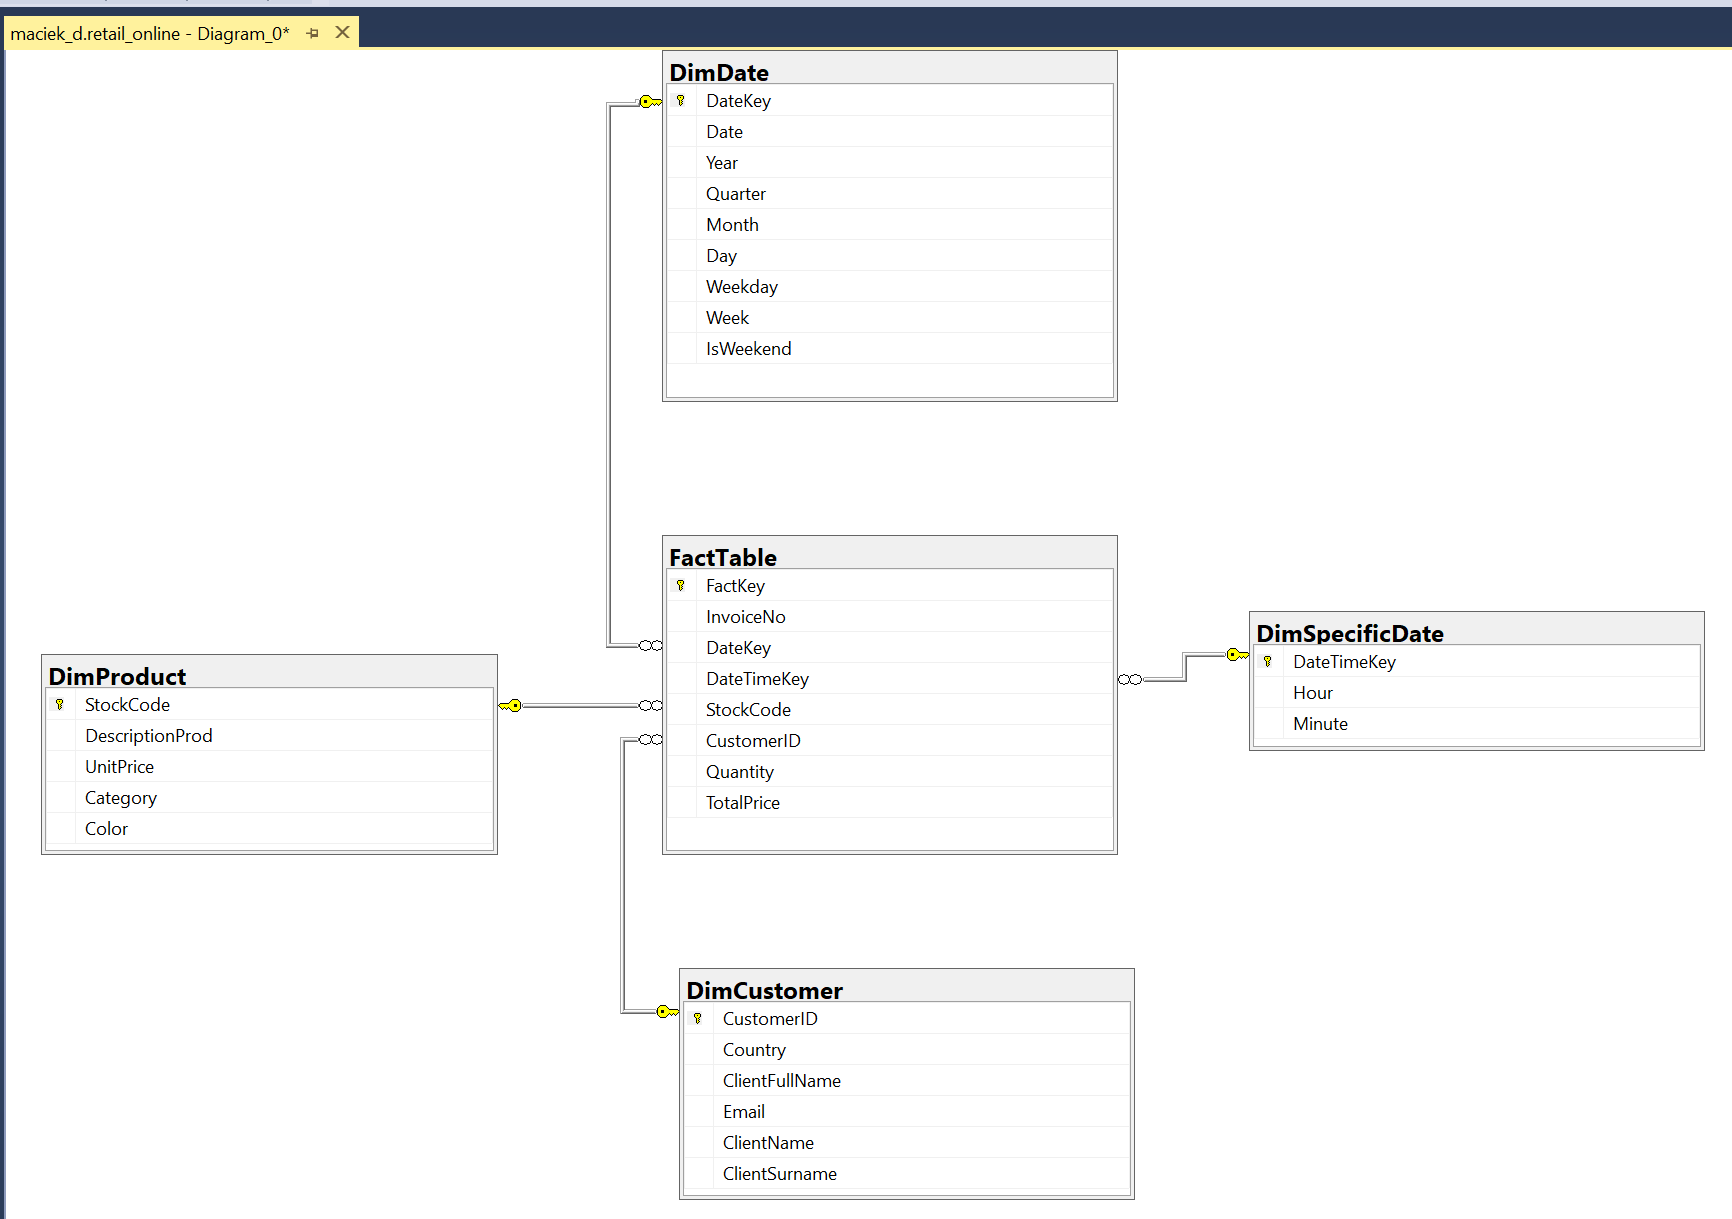

In [48]:
from IPython.display import Image, display

display(Image(filename='DatabaseDiagram.png', width=900))